<a id = "table_of_contents"></a>
# Table of contents

[Import of libraries](#imports)

[Global variables](#global_variables)

[Sales import and generate a full df with all data and records](#generate_full_df_with_all_records)

[Join the full_df with gb_df](#join_dfs)

[Generate additional features](#create_new_features)

-->[Date and shop_id features](#feature_1)

-->[Date and item_category features](#feature_3)

[Join full sales df with all the features generated](#join_dfs_with_features)

[Basic model train](#basic_model)

[Feature importance](#feature_importance_1)

[Predict and model evaluation](#predict_and_model_evaluation_1)

[Submission to Kaggle](#submission_kaggle)

<a id = "imports"></a>
# Import of libraries
[Go back to the table of contents](#table_of_contents)

In [1]:
# import the basic libraries we will use in this kernel
import os
import numpy as np
import pandas as pd
import pickle

import time
import datetime
from datetime import datetime
import calendar

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

<a id = "global_variables"></a>
# Global variables
[Go back to the table of contents](#table_of_contents)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = "generate_full_df_with_all_records"></a>
# Sales import and generate a full df with all data and records
[Go back to the table of contents](#table_of_contents)

In [3]:
sales_df = pd.read_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/DF_FINAL.csv", index_col = 0)

In [4]:
cols_to_drop = [
 "day", "sales_2011", "sales_2012", "sales_2013"
]

sales_df.drop(cols_to_drop, inplace = True, axis = 1)

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5345528 entries, 0 to 5345527
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               object 
 1   item             object 
 2   category         object 
 3   department       object 
 4   store            object 
 5   store_code       object 
 6   region           object 
 7   date             object 
 8   sell_price       float64
 9   year             int64  
 10  week             int64  
 11  sales            float64
 12  month            int64  
 13  weekday_int      float64
 14  weekend_sales    float64
 15  event_dummy      float64
 16  event_sales      float64
 17  units            int64  
 18  summer_sales     int64  
 19  christmas_sales  int64  
 20  sales_2014       int64  
 21  sales_2015       int64  
 22  sales_2016       int64  
dtypes: float64(6), int64(9), object(8)
memory usage: 978.8+ MB


In [6]:
sales_df.isnull().sum()

id                 0
item               0
category           0
department         0
store              0
store_code         0
region             0
date               0
sell_price         0
year               0
week               0
sales              0
month              0
weekday_int        0
weekend_sales      0
event_dummy        0
event_sales        0
units              0
summer_sales       0
christmas_sales    0
sales_2014         0
sales_2015         0
sales_2016         0
dtype: int64

In [7]:
sales_df.rename(columns={'id': 'unique_id', 'units': 'item_cnt_day', 'sell_price': 'item_price', "sales" : "revenue"}, inplace=True)

In [8]:
x = sales_df["revenue"].mean()
print(x)
print(len(sales_df))
sales_df.drop(sales_df[sales_df['revenue'] <= x].index, inplace = True)
print(len(sales_df))

34.95851388487722
5345528
1482691


In [9]:
x = sales_df["revenue"].mean()
print(x)
print(len(sales_df))
sales_df.drop(sales_df[sales_df['revenue'] <= x].index, inplace = True)
print(len(sales_df))

99.01576923310391
1482691
405603


In [10]:
type(sales_df["date"].iloc[0])

str

In [11]:
# convert to datetime the date column
# specify the format since otherwise it might give some problems
sales_df["date"] = pd.to_datetime(sales_df["date"], format = "%Y-%m-%d")

In [12]:
# max date in sales is 30.09.2015.
# In the Kaggle competition we are asked to predict the sales for the next month
# this means the sales of October
min_date = sales_df["date"].min()
max_date_sales = sales_df["date"].max()

In [13]:
max_date_sales

Timestamp('2016-04-18 00:00:00')

In [14]:
# how to create a new date
max_date_test = datetime(2016, 4, 18)

In [15]:
date_range = pd.date_range(min_date, max_date_test, freq = "W")
print("We have a total of {} weeks".format(len(date_range)))
date_range

We have a total of 267 weeks


DatetimeIndex(['2011-03-13', '2011-03-20', '2011-03-27', '2011-04-03',
               '2011-04-10', '2011-04-17', '2011-04-24', '2011-05-01',
               '2011-05-08', '2011-05-15',
               ...
               '2016-02-14', '2016-02-21', '2016-02-28', '2016-03-06',
               '2016-03-13', '2016-03-20', '2016-03-27', '2016-04-03',
               '2016-04-10', '2016-04-17'],
              dtype='datetime64[ns]', length=267, freq='W-SUN')

In [16]:
unique_id = sales_df["unique_id"].unique()

In [17]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "unique_id"])
len(cartesian_product)

2882532

We will be working with a DataFrame resampled by Months. We must resample the sales_df.

In [18]:
# # set index
sales_df["revenue"] = sales_df["item_cnt_day"] * sales_df["item_price"]

In [19]:
sales_df.head(5)

,unique_id,item,category,department,store,store_code,region,date,item_price,year,...,weekday_int,weekend_sales,event_dummy,event_sales,item_cnt_day,summer_sales,christmas_sales,sales_2014,sales_2015,sales_2016
5,ACCESORIES_1_004_BOS_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,2011-03-07,5.77,2011,...,26.0,4.0,0.0,0.0,25,0,0,0,0,0
7,ACCESORIES_1_004_NYC_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,2011-03-07,5.77,2011,...,21.0,13.0,0.0,0.0,22,0,0,0,0,0
11,ACCESORIES_1_004_PHI_3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Queen_Village,PHI_3,Philadelphia,2011-03-07,5.77,2011,...,28.0,9.0,0.0,0.0,33,0,0,0,0,0
16,ACCESORIES_1_008_NYC_3,ACCESORIES_1_008,ACCESORIES,ACCESORIES_1,Tribeca,NYC_3,New York,2011-03-07,0.56,2011,...,28.0,89.0,0.0,0.0,187,0,0,0,0,0
91,ACCESORIES_1_023_BOS_3,ACCESORIES_1_023,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,2011-03-07,4.58,2011,...,28.0,23.0,0.0,0.0,40,0,0,0,0,0


In [20]:
sales_df.item_price.describe()

count    405603.000000
mean          7.359349
std           6.190252
min           0.240000
25%           3.000000
50%           5.380000
75%           9.960000
max         134.150000
Name: item_price, dtype: float64

In [21]:
print(len(sales_df))

405603


In [22]:
st = time.time()

gb_df = sales_df.set_index("date")

# # groupby shop_id and item_id
gb_df = gb_df.groupby(["unique_id"])

# # resample the sales to a monthly basis
gb_df = gb_df.resample("W").agg({'item_cnt_day':np.sum, "item_price":np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
gb_df.reset_index(inplace = True)

et = time.time()

print("Total time in minutes to preprocess took {}".format((et - st)/60))

Total time in minutes to preprocess took 3.1620582501093546


In [23]:
gb_df.head(2)

,unique_id,date,item_cnt_day,item_price,revenue
0,ACCESORIES_1_001_NYC_1,2014-09-07,10,10.99,109.9
1,ACCESORIES_1_001_NYC_1,2014-09-14,0,NaN,0.0


In [24]:
print(len(gb_df))

1380793


In [25]:
additional_info_2 = sales_df[["year", "month", "weekday_int", "weekend_sales", "event_dummy", "summer_sales", "christmas_sales","sales_2014", "sales_2015", "sales_2016", "unique_id"]].drop_duplicates()
additional_info_2.to_pickle("./additional_info_2")

In [26]:
gb_df.to_pickle("gb_df.pkl")
sales_df.to_pickle("sales_df.pkl")

<a id = "join_dfs"></a>
# Join the full_df with gb_df
[Go back to the table of contents](#table_of_contents)

Now that we have the sales_df resampled by months, and we have created a cartesian product (all possible combinations of months, shop_id and item_id), let's merge the df.

In [27]:
# PATH_DATA = "../input/df-time-series"
gb_df = pd.read_pickle("./gb_df.pkl")
sales_df = pd.read_pickle("./sales_df.pkl")

In [28]:
# max date in sales is 30.09.2015.
# In the Kaggle competition we are asked to predict the sales for the next month
# this means the sales of October
min_date = sales_df["date"].min()
max_date_sales = sales_df["date"].max()
# how to create a new date
max_date_test = datetime(2016, 4, 18)
date_range = pd.date_range(min_date, max_date_test, freq = "M")
print("We have a total of {} months".format(len(date_range)))
date_range
unique_id = sales_df["unique_id"].unique()
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "unique_id"])
len(cartesian_product)

We have a total of 61 months


658556

In [29]:
sales_df.head(2)

,unique_id,item,category,department,store,store_code,region,date,item_price,year,...,weekday_int,weekend_sales,event_dummy,event_sales,item_cnt_day,summer_sales,christmas_sales,sales_2014,sales_2015,sales_2016
5,ACCESORIES_1_004_BOS_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,2011-03-07,5.77,2011,...,26.0,4.0,0.0,0.0,25,0,0,0,0,0
7,ACCESORIES_1_004_NYC_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,2011-03-07,5.77,2011,...,21.0,13.0,0.0,0.0,22,0,0,0,0,0


In [30]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

full_df = pd.merge(full_df, gb_df, on = ['date','unique_id'], how = 'left')

full_df["item_cnt_day"] = np.clip(full_df["item_cnt_day"], 0, 30)

In [31]:
print(len(sales_df))
print(len(gb_df))

405603
1380793


In [32]:
gb_df.revenue.describe()

count    1.380793e+06
mean     6.184128e+01
std      1.429971e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.100000e+02
max      8.629140e+03
Name: revenue, dtype: float64

In [33]:
y = gb_df["revenue"].mean()
print(y)
print(len(gb_df))
gb_df.drop(gb_df[gb_df['revenue'] <= y].index, inplace = True)
print(len(gb_df))

61.84127828718712
1380793
405603


In [34]:
gb_df.head()

,unique_id,date,item_cnt_day,item_price,revenue
0,ACCESORIES_1_001_NYC_1,2014-09-07,10,10.99,109.90
80,ACCESORIES_1_001_NYC_1,2016-03-20,10,10.99,109.90
83,ACCESORIES_1_001_NYC_1,2016-04-10,12,10.99,131.88
84,ACCESORIES_1_001_NYC_2,2016-04-24,10,11.15,111.50
85,ACCESORIES_1_001_NYC_3,2013-09-29,12,10.99,131.88


In [35]:
print(full_df.shape)

(658556, 5)


In [36]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658556 entries, 0 to 658555
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          658556 non-null  datetime64[ns]
 1   unique_id     658556 non-null  object        
 2   item_cnt_day  42879 non-null   float64       
 3   item_price    11877 non-null   float64       
 4   revenue       42879 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 30.1+ MB


In [37]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405603 entries, 5 to 5345476
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique_id        405603 non-null  object        
 1   item             405603 non-null  object        
 2   category         405603 non-null  object        
 3   department       405603 non-null  object        
 4   store            405603 non-null  object        
 5   store_code       405603 non-null  object        
 6   region           405603 non-null  object        
 7   date             405603 non-null  datetime64[ns]
 8   item_price       405603 non-null  float64       
 9   year             405603 non-null  int64         
 10  week             405603 non-null  int64         
 11  revenue          405603 non-null  float64       
 12  month            405603 non-null  int64         
 13  weekday_int      405603 non-null  float64       
 14  weekend_sales    40

In [38]:
additional_info = sales_df[["region", "store_code", "store", "category", "item", "department", "unique_id"]].drop_duplicates()

In [39]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = additional_info,
    how = "left",
    on = "unique_id"
)
print(full_df.shape)

(658556, 5)
(658556, 11)


In [40]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658556 entries, 0 to 658555
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          658556 non-null  datetime64[ns]
 1   unique_id     658556 non-null  object        
 2   item_cnt_day  42879 non-null   float64       
 3   item_price    11877 non-null   float64       
 4   revenue       42879 non-null   float64       
 5   region        658556 non-null  object        
 6   store_code    658556 non-null  object        
 7   store         658556 non-null  object        
 8   category      658556 non-null  object        
 9   item          658556 non-null  object        
 10  department    658556 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 60.3+ MB


In [41]:
full_df["item_cnt_day"].fillna(0, inplace = True)
full_df["item_price"].fillna(0, inplace = True)
full_df["revenue"].fillna(0, inplace = True)

In [42]:
full_df["item_price"] = full_df.groupby("unique_id")["item_price"].apply(lambda series: series.backfill().ffill())

In [43]:
full_df.isnull().sum()

date            0
unique_id       0
item_cnt_day    0
item_price      0
revenue         0
region          0
store_code      0
store           0
category        0
item            0
department      0
dtype: int64

In [44]:
full_df.to_pickle("full_df.pkl")

<a id = "create_new_features"></a>
# Generate additional features
[Go back to the table of contents](#table_of_contents)

In [45]:
PATH_DATA = "../input/df-time-series"
full_df = pd.read_pickle("./full_df.pkl")

In [46]:
encoder = LabelEncoder()
encoder.fit(full_df["region"])
full_df["region"] = encoder.transform(full_df["region"])
full_df["region"] = LabelEncoder().fit_transform(full_df["region"])

encoder = LabelEncoder()
encoder.fit(full_df["store_code"])
full_df["store_code"] = encoder.transform(full_df["store_code"])
full_df["store_code"] = LabelEncoder().fit_transform(full_df["store_code"])

encoder = LabelEncoder()
encoder.fit(full_df["category"])
full_df["category"] = encoder.transform(full_df["category"])
full_df["category"] = LabelEncoder().fit_transform(full_df["category"])

encoder = LabelEncoder()
encoder.fit(full_df["department"])
full_df["department"] = encoder.transform(full_df["department"])
full_df["department"] = LabelEncoder().fit_transform(full_df["department"])

encoder = LabelEncoder()
encoder.fit(full_df["item"])
full_df["item"] = encoder.transform(full_df["item"])
full_df["item"] = LabelEncoder().fit_transform(full_df["item"])

In [47]:
def build_ts_features(full_df, gb_list, agg_func, agg_func_name, target_column = "item_cnt_day", verbose = True) -> pd.DataFrame:
    '''
    Based on the full_df you pass and the gb_list, this functions creates Time Series features and returns
    a gb_df.
    '''
    
    # create dynamic name
    feature_name = "_".join(gb_list)
    
    if verbose: print(f"Working with {feature_name}")
    
    # first sales/DataFrame aggregation
    gb_df = full_df.groupby(
        gb_list
    )[target_column].apply(
        agg_func
    ).reset_index().rename(
        columns = {target_column : feature_name + "_" + agg_func_name}
    )
    
    # add lags features
    gb_df[feature_name + "_" + agg_func_name + "_" + "shift_1"] = gb_df.groupby(gb_list[1:])[feature_name + "_" + agg_func_name].transform(
        lambda series: series.shift(1)
    )
    
    return gb_df

In [48]:
additional_info_2 = pd.read_pickle("./additional_info_2")

In [49]:
additional_info_2.unique_id.value_counts

<bound method IndexOpsMixin.value_counts of 5           ACCESORIES_1_004_BOS_2
7           ACCESORIES_1_004_NYC_2
11          ACCESORIES_1_004_PHI_3
16          ACCESORIES_1_008_NYC_3
91          ACCESORIES_1_023_BOS_3
                    ...           
5345434    SUPERMARKET_3_818_NYC_4
5345471    SUPERMARKET_3_822_NYC_1
5345472    SUPERMARKET_3_822_NYC_2
5345473    SUPERMARKET_3_822_NYC_3
5345476    SUPERMARKET_3_822_PHI_2
Name: unique_id, Length: 400689, dtype: object>

In [50]:
full_df.unique_id.value_counts

<bound method IndexOpsMixin.value_counts of 0            ACCESORIES_1_004_BOS_2
1            ACCESORIES_1_004_NYC_2
2            ACCESORIES_1_004_PHI_3
3            ACCESORIES_1_008_NYC_3
4            ACCESORIES_1_023_BOS_3
                    ...            
658551    HOME_&_GARDEN_1_161_PHI_3
658552    HOME_&_GARDEN_1_284_BOS_2
658553    HOME_&_GARDEN_2_405_NYC_3
658554    HOME_&_GARDEN_2_492_NYC_1
658555      SUPERMARKET_3_247_NYC_3
Name: unique_id, Length: 658556, dtype: object>

In [51]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = additional_info_2,
    how = "left",
    on = "unique_id"
)
print(full_df.shape)

(658556, 11)
(24442029, 21)


In [52]:
print(len(full_df))
full_df.drop(full_df[full_df['revenue'] == 0].index, inplace = True)
print(len(full_df))

24442029
1322739


In [53]:
full_df.isnull().sum()

date               0
unique_id          0
item_cnt_day       0
item_price         0
revenue            0
region             0
store_code         0
store              0
category           0
item               0
department         0
year               0
month              0
weekday_int        0
weekend_sales      0
event_dummy        0
summer_sales       0
christmas_sales    0
sales_2014         0
sales_2015         0
sales_2016         0
dtype: int64

In [54]:
full_df.to_pickle("full_df.pk2")

<a id = "feature_1"></a>
## Date and shop_id features
[Go back to the table of contents](#table_of_contents)

In [55]:
full_df = pd.read_pickle("./full_df.pk2")

In [56]:
st = time.time()

gb_list = ["date", "store_code"]

shop_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_store_code


0.003347349166870117

In [57]:
shop_sales_features.shape

(70, 4)

In [58]:
st = time.time()

gb_list = ["date", "region"]

region_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_region


0.0023633122444152834

In [59]:
st = time.time()

gb_list = ["date", "department"]

department_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_department


0.0025115648905436197

In [60]:
department_sales_features

,date,department,date_department_sales_sum,date_department_sales_sum_shift_1
0,2011-07-31,0,223124.0,NaN
1,2011-07-31,1,72.0,NaN
2,2011-07-31,2,718376.0,NaN
3,2011-07-31,3,54559.0,NaN
4,2011-07-31,4,107264.0,NaN
5,2011-07-31,5,414645.0,NaN
6,2011-07-31,6,2105643.0,NaN
7,2012-09-30,0,292126.0,223124.0
8,2012-09-30,2,1124676.0,718376.0
9,2012-09-30,3,69380.0,54559.0


In [61]:
st = time.time()

gb_list = ["date", "month"]

month_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_month


0.0028935670852661133

In [62]:
month_sales_features

,date,month,date_month_sales_sum,date_month_sales_sum_shift_1
0,2011-07-31,3,411423.0,NaN
1,2011-07-31,4,401120.0,NaN
2,2011-07-31,5,342637.0,NaN
3,2011-07-31,6,378965.0,NaN
4,2011-07-31,7,401816.0,NaN
...,...,...,...,...
65,2015-05-31,8,478800.0,433228.0
66,2015-05-31,9,496756.0,456058.0
67,2015-05-31,10,472660.0,449791.0
68,2015-05-31,11,449997.0,460604.0


In [63]:
st = time.time()

gb_list = ["date", "weekend_sales"]

weekend_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_weekend_sales


0.010029192765553792

In [64]:
weekend_sales_features

,date,weekend_sales,date_weekend_sales_sales_sum,date_weekend_sales_sales_sum_shift_1
0,2011-07-31,0.0,42016.0,NaN
1,2011-07-31,1.0,38984.0,NaN
2,2011-07-31,2.0,69148.0,NaN
3,2011-07-31,3.0,97030.0,NaN
4,2011-07-31,4.0,123303.0,NaN
...,...,...,...,...
3053,2015-05-31,396.0,30.0,30.0
3054,2015-05-31,402.0,30.0,30.0
3055,2015-05-31,434.0,30.0,30.0
3056,2015-05-31,444.0,30.0,30.0


In [65]:
st = time.time()

gb_list = ["date", "summer_sales"]

summer_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_summer_sales


0.016533597310384115

In [66]:
summer_sales_features

,date,summer_sales,date_summer_sales_sales_sum,date_summer_sales_sales_sum_shift_1
0,2011-07-31,0,2453596.0,NaN
1,2011-07-31,5,2089.0,NaN
2,2011-07-31,6,4709.0,NaN
3,2011-07-31,7,7721.0,NaN
4,2011-07-31,8,9224.0,NaN
...,...,...,...,...
5556,2015-05-31,1020,30.0,30.0
5557,2015-05-31,1031,60.0,30.0
5558,2015-05-31,1104,30.0,30.0
5559,2015-05-31,1172,30.0,30.0


In [67]:
st = time.time()

gb_list = ["date", "christmas_sales"]

christmas_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_christmas_sales


0.011496055126190185

In [68]:
christmas_sales_features

,date,christmas_sales,date_christmas_sales_sales_sum,date_christmas_sales_sales_sum_shift_1
0,2011-07-31,0,3344177.0,NaN
1,2011-07-31,5,438.0,NaN
2,2011-07-31,6,1194.0,NaN
3,2011-07-31,7,1940.0,NaN
4,2011-07-31,8,2612.0,NaN
...,...,...,...,...
3699,2015-05-31,885,30.0,30.0
3700,2015-05-31,887,30.0,30.0
3701,2015-05-31,959,30.0,30.0
3702,2015-05-31,972,30.0,30.0


In [69]:
st = time.time()

gb_list = ["date", "item"]

item_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_item


0.016569769382476805

In [70]:
item_sales_features

,date,item,date_item_sales_sum,date_item_sales_sum_shift_1
0,2011-07-31,2,11670.0,NaN
1,2011-07-31,5,720.0,NaN
2,2011-07-31,13,1700.0,NaN
3,2011-07-31,15,4291.0,NaN
4,2011-07-31,34,3908.0,NaN
...,...,...,...,...
3909,2015-05-31,2061,1700.0,1700.0
3910,2015-05-31,2064,44160.0,34500.0
3911,2015-05-31,2070,28200.0,27690.0
3912,2015-05-31,2076,3360.0,3360.0


<a id = "feature_3"></a>
## Date and item_category features
[Go back to the table of contents](#table_of_contents)

In [71]:
st = time.time()

gb_list = ["date", "category"]

month_item_category_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_category


0.0022879679997762042

In [72]:
month_item_category_features.shape

(21, 4)

<a id = "join_dfs_with_features"></a>
# Join full sales df with all the features generated
[Go back to the table of contents](#table_of_contents)

In [73]:
print("Shape before merge is {}".format(full_df.shape))

full_df = pd.merge(full_df, shop_sales_features, on = ["date", "store_code"], how = "left")
full_df = pd.merge(full_df, month_item_category_features, on = ["date", "category"], how = "left")
full_df = pd.merge(full_df, item_sales_features, on = ["date", "item"], how = "left")
full_df = pd.merge(full_df, christmas_sales_features, on = ["date", "christmas_sales"], how = "left")
full_df = pd.merge(full_df, summer_sales_features, on = ["date", "summer_sales"], how = "left")
full_df = pd.merge(full_df, weekend_sales_features, on = ["date", "weekend_sales"], how = "left")
full_df = pd.merge(full_df, month_sales_features, on = ["date", "month"], how = "left")
full_df = pd.merge(full_df, department_sales_features, on = ["date", "department"], how = "left")
full_df = pd.merge(full_df, region_sales_features, on = ["date", "region"], how = "left")

full_df.rename(columns = {"item_cnt_day":"sales"}, inplace = True)

print("Shape after merge is {}".format(full_df.shape))

Shape before merge is (1322739, 21)
Shape after merge is (1322739, 39)


In [74]:
full_df.to_pickle("full_df.pk3")
full_df = pd.read_pickle("./full_df.pk3")

In [75]:
# save the file

st = time.time()

full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

et = time.time()
(et - st)/60

0.01983359654744466

<a id = "basic_model"></a>
# Basic model train
[Go back to the table of contents](#table_of_contents)

In [76]:
# load the preprocessed data
full_df = pd.read_pickle("./FULL_DF_ALL_FEATURES.pkl")
full_df["sales"] = np.clip(full_df["sales"], 0, 30)

# delete all the columns where lags features are - 1 (shift(1))
full_df = full_df[full_df["date"] > np.datetime64("2011-01-31")]

In [77]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322739 entries, 0 to 1322738
Data columns (total 39 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   date                                    1322739 non-null  datetime64[ns]
 1   unique_id                               1322739 non-null  object        
 2   sales                                   1322739 non-null  float64       
 3   item_price                              1322739 non-null  float64       
 4   revenue                                 1322739 non-null  float64       
 5   region                                  1322739 non-null  int64         
 6   store_code                              1322739 non-null  int64         
 7   store                                   1322739 non-null  object        
 8   category                                1322739 non-null  int64         
 9   item                    

In [78]:
full_df.isnull().sum()

date                                           0
unique_id                                      0
sales                                          0
item_price                                     0
revenue                                        0
region                                         0
store_code                                     0
store                                          0
category                                       0
item                                           0
department                                     0
year                                           0
month                                          0
weekday_int                                    0
weekend_sales                                  0
event_dummy                                    0
summer_sales                                   0
christmas_sales                                0
sales_2014                                     0
sales_2015                                     0
sales_2016          

In [79]:
full_df["date_store_code_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_category_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_item_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_summer_sales_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_weekend_sales_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_month_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_department_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_region_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_christmas_sales_sales_sum_shift_1"].fillna(0, inplace = True)

In [80]:
cols_to_drop = [

'revenue',
'store',
"unique_id",
"date_store_code_sales_sum",
"date_category_sales_sum", 
"date_region_sales_sum",
"date_department_sales_sum", 
"date_month_sales_sum", 
"date_weekend_sales_sales_sum", 
"date_summer_sales_sales_sum", 
"date_christmas_sales_sales_sum", 
"date_item_sales_sum"
    
]

full_df.drop(cols_to_drop, inplace = True, axis = 1)

In [81]:
full_df.head()

,date,sales,item_price,region,store_code,category,item,department,year,month,...,sales_2016,date_store_code_sales_sum_shift_1,date_category_sales_sum_shift_1,date_item_sales_sum_shift_1,date_christmas_sales_sales_sum_shift_1,date_summer_sales_sales_sum_shift_1,date_weekend_sales_sales_sum_shift_1,date_month_sales_sum_shift_1,date_department_sales_sum_shift_1,date_region_sales_sum_shift_1
0,2011-07-31,30.0,5.77,1,4,0,2,0,2011,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-07-31,30.0,5.77,1,4,0,2,0,2011,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-07-31,30.0,5.77,1,4,0,2,0,2011,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-07-31,30.0,5.77,1,4,0,2,0,2011,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-07-31,30.0,5.77,1,4,0,2,0,2011,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(full_df["date"].unique()))[:-2]

valida_index = [sorted(list(full_df["date"].unique()))[-2]]

test_index = [sorted(list(full_df["date"].unique()))[-1]]

In [83]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = full_df[full_df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = full_df[full_df["date"].isin(train_index)]['sales']

X_valida = full_df[full_df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = full_df[full_df["date"].isin(valida_index)]['sales']

X_test = full_df[full_df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = full_df[full_df["date"].isin(test_index)]['sales']

In [84]:
st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[00:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22.8096	validation_1-rmse:22.3774
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:20.6542	validation_1-rmse:20.187
[2]	validation_0-rmse:18.623	validation_1-rmse:18.2256
[3]	validation_0-rmse:16.8289	validation_1-rmse:16.4607
[4]	validation_0-rmse:15.2758	validation_1-rmse:14.8753
[5]	validation_0-rmse:13.8448	validation_1-rmse:13.4598
[6]	validation_0-rmse:12.601	validation_1-rmse:12.1983
[7]	validation_0-rmse:11.45	validation_1-rmse:11.0757
[8]	validation_0-rmse:10.4318	validation_1-rmse:10.0865
[9]	validation_0-rmse:9.55742	validation_1-rmse:9.19618
[10]	validation_0-rmse:8.78296	validation_1-rmse:8.4097
[11]	validation_0-rmse:8.08515	validation_1-rmse:7.71808
[12]	validation_0-rmse:7.44525	validation_1-rm

In [85]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [86]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_10_17_00_41_17.dat


In [87]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

[00:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<a id = "feature_importance_1"></a>
# Feature importance
[Go back to the table of contents](#table_of_contents)

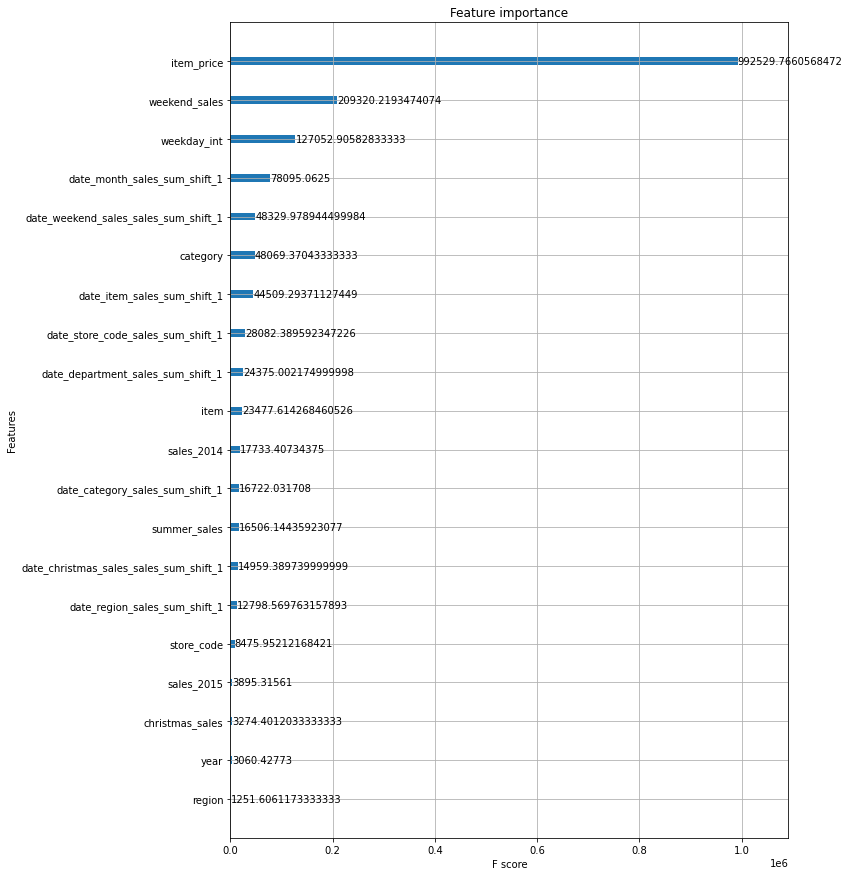

In [88]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

<a id = "predict_and_model_evaluation_1"></a>
# Predict and model evaluation
[Go back to the table of contents](#table_of_contents)

In [89]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

3.505199139578527

In [90]:
if "sales_predicted" in X_test.columns:
    X_test.drop("sales_predicted", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["sales_predicted"] = np.clip(Y_test_predict, 0, 30)

In [91]:
X_test.head()

,item_price,region,store_code,category,item,department,year,month,weekday_int,weekend_sales,...,date_store_code_sales_sum_shift_1,date_category_sales_sum_shift_1,date_item_sales_sum_shift_1,date_christmas_sales_sales_sum_shift_1,date_summer_sales_sales_sum_shift_1,date_weekend_sales_sales_sum_shift_1,date_month_sales_sum_shift_1,date_department_sales_sum_shift_1,date_region_sales_sum_shift_1,sales_predicted
1118029,6.17,1,4,0,2,0,2011,3,21.0,13.0,...,284336.0,215396.0,10524.0,4063718.0,3155800.0,137575.0,514490.0,214625.0,2239354.0,23.994532
1118030,6.17,1,4,0,2,0,2011,3,28.0,12.0,...,284336.0,215396.0,10524.0,4063718.0,3155800.0,150885.0,514490.0,214625.0,2239354.0,23.753328
1118031,6.17,1,4,0,2,0,2011,3,27.0,6.0,...,284336.0,215396.0,10524.0,4063718.0,3155800.0,156594.0,514490.0,214625.0,2239354.0,22.315289
1118032,6.17,1,4,0,2,0,2011,3,16.0,22.0,...,284336.0,215396.0,10524.0,4063718.0,3155800.0,76843.0,514490.0,214625.0,2239354.0,25.725317
1118033,6.17,1,4,0,2,0,2011,4,28.0,10.0,...,284336.0,215396.0,10524.0,4063718.0,3155800.0,155905.0,483532.0,214625.0,2239354.0,23.045853


In [92]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204710 entries, 1118029 to 1322738
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   item_price                              204710 non-null  float64
 1   region                                  204710 non-null  int64  
 2   store_code                              204710 non-null  int64  
 3   category                                204710 non-null  int64  
 4   item                                    204710 non-null  int64  
 5   department                              204710 non-null  int64  
 6   year                                    204710 non-null  int64  
 7   month                                   204710 non-null  int64  
 8   weekday_int                             204710 non-null  float64
 9   weekend_sales                           204710 non-null  float64
 10  event_dummy                          

In [103]:
X_test.to_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/STOCK_PREDICTION_DF_10.csv", index = False)

In [94]:
X_test["unique_id"] = X_test["store_code"].map(str) + "-" + X_test["item"].map(str)

In [95]:
X_test_short = X_test[["unique_id", "sales_predicted"]]

In [96]:
PATH_DATA = "../input/df-time-series"

In [97]:
test_index = pd.read_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/DF_FINAL.csv")

In [98]:
test_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345528 entries, 0 to 5345527
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   id               object 
 2   item             object 
 3   category         object 
 4   department       object 
 5   store            object 
 6   store_code       object 
 7   region           object 
 8   date             object 
 9   sell_price       float64
 10  year             int64  
 11  week             int64  
 12  sales            float64
 13  month            int64  
 14  day              int64  
 15  weekday_int      float64
 16  weekend_sales    float64
 17  event_dummy      float64
 18  event_sales      float64
 19  units            int64  
 20  summer_sales     int64  
 21  christmas_sales  int64  
 22  sales_2011       int64  
 23  sales_2012       int64  
 24  sales_2013       int64  
 25  sales_2014       int64  
 26  sales_2015       int64  
 27  sales_2016  

In [99]:
test_index["id"] = test_index["id"].map(str)
test_index.rename(columns = {"id":"unique_id"}, inplace = True)

In [100]:
FINAL_STOCK_PRED_DF = pd.merge(test_index, X_test_short, left_on = "unique_id", right_on = "unique_id", how = "left")

In [104]:
FINAL_STOCK_PRED_DF.to_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/FINAL_STOCK_PRED_DF_10.csv", index = False)

In [102]:
FINAL_STOCK_PRED_DF.head(2)

,Unnamed: 0,unique_id,item,category,department,store,store_code,region,date,sell_price,...,units,summer_sales,christmas_sales,sales_2011,sales_2012,sales_2013,sales_2014,sales_2015,sales_2016,sales_predicted
0,0,ACCESORIES_1_002_BOS_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-03-07,5.28,...,4,0,0,4,0,0,0,0,0,NaN
1,1,ACCESORIES_1_002_BOS_3,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,2011-03-07,5.28,...,2,0,0,2,0,0,0,0,0,NaN
